In [2]:
import numpy as np
#from dataclasses import dataclass, field
#from typing import List, Dict, Optional, Tuple

In [5]:
from uavmec.system import Vehicle, RSU, UAV, UavVecWorld
from uavmec.plot_world import plot_world

In [4]:
import os

traj_dir = "__data__/Geolife Trajectories Corrected"
traj_files = os.listdir(traj_dir)

np.random.shuffle(traj_files)


In [12]:
def scale_trajectory(traj, x_min, x_max, y_min, y_max):
    tx = (traj[:, 0] - traj[:, 0].min()) / (np.ptp(traj[:, 0]) + 1e-9)
    ty = (traj[:, 1] - traj[:, 1].min()) / (np.ptp(traj[:, 1]) + 1e-9)

    x_scaled = x_min + tx * (x_max - x_min)
    y_scaled = y_min + ty * (y_max - y_min)

    return np.stack([x_scaled, y_scaled], axis=1)


In [21]:
# ============================================
# Example world construction & one step (MULTI-UAV)
# ============================================
"""
        action format:
    {
        "coalitions": {
            coalition_id: [uav_id_1, uav_id_2, ...],
            ...
        },
        "rsu_assignment": {
            rsu_id: coalition_id,
            ...
        }
    }
        """
        
# ----- Example parameters -----
M = 100   # vehicles
U = 1    # UAVs
T = 500  #timesteps
grid_size=7
grid_spacing=300.0



# RSUs
rsus = []
rid=0
for i in range(grid_size):
    for j in range(grid_size):
        x = i * grid_spacing
        y = j * grid_spacing

        # CPU in [4, 8] GHz
        f_max = np.random.uniform(4e9, 8e9)

        bandwidth = 20e6
        noise_power = 1e-13
        tx_power = 1.0

        # Optional GPU (keep or remove depending on your extension)
        gpu_flops = 1e12 if (rid % 2 == 0) else 0.0
        gpu_memory = 4096 if gpu_flops > 0 else 0.0
        gpu_power_active = 120.0 if gpu_flops > 0 else 0.0

        rsus.append(
            RSU(
                rid, x, y,
                f_max, bandwidth, noise_power, tx_power,
                gpu_flops, gpu_memory, gpu_power_active
            )
        )
        rid += 1
# Vehicles
vehicles = []
for vid in range(M):
    traj = np.load(os.path.join(traj_dir, traj_files[vid]))

    lam = 2*np.random.rand() + 1
    c_task = 5e8
    d_task = 5e5

    traj_scaled = scale_trajectory(
        traj,
        x_min=0.0,
        x_max=grid_spacing * (grid_size - 1),
        y_min=0.0,
        y_max=grid_spacing * (grid_size - 1),
    )

    vehicles.append(
        Vehicle(
            vid=vid,
            lam=lam,
            c_per_task=c_task,
            d_per_task=d_task,
            trajectory=traj_scaled
        )
    )

# UAVs (MULTIPLE)
uavs = []
for uid in range(U):
    uavs.append(
        UAV(
            uid=uid,
            x=0.0,
            y=0.0,
            H=30.0,  #given in paper [24]
            f_u=5e9, # 5GHz
            hover_power=220.0,
            energy_coeff=1e-28,
            fly_coeff=1.0,
            gpu_flops=2e12,
            gpu_memory=8192,
            gpu_power_active=200.0,
            E_max=5e5,
            E_batt=5e5,
            EH_max=1e3,
            mu1=15.0,
            mu2=0.5,
            g0=1.0,
            zeta=0.2,
            H0=0.0
        )
    )

# World
world = UavVecWorld(
    vehicles=vehicles,
    rsus=rsus,
    uavs=uavs,                     # <<< CHANGED
    delta_t=1.0,
    rsu_capacity_threshold=4e8,
    uplink_power_ue=0.5,
    uplink_noise_ue=1e-13,
    rsu_radius=300.0
)

world.reset()


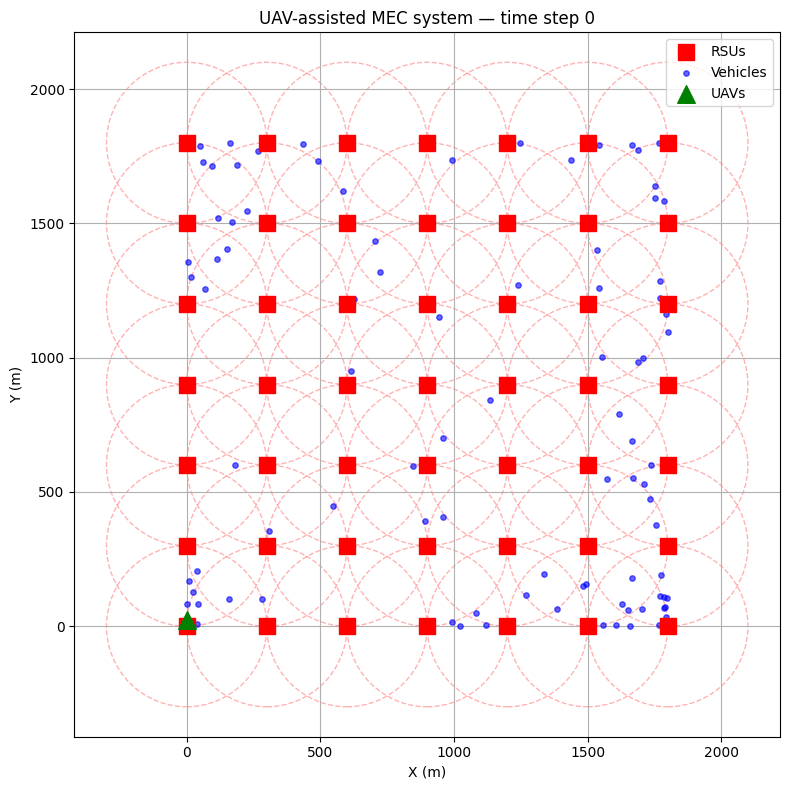

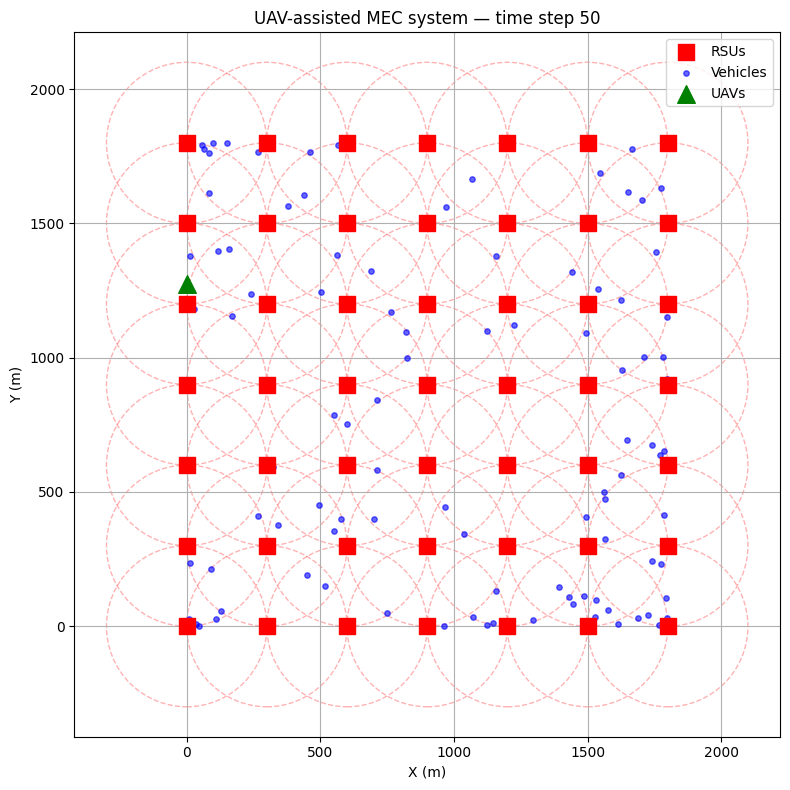

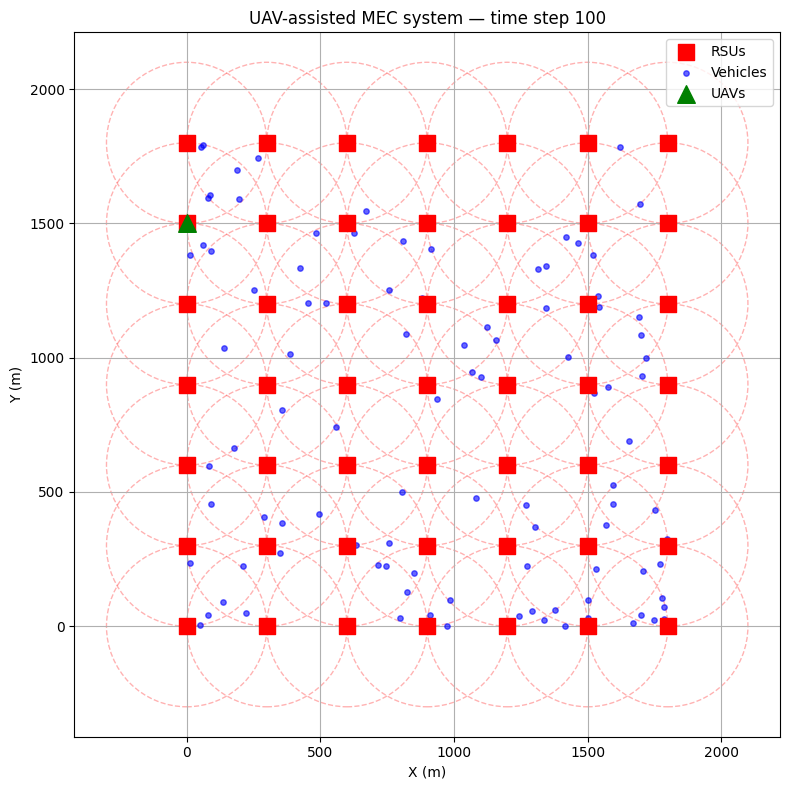

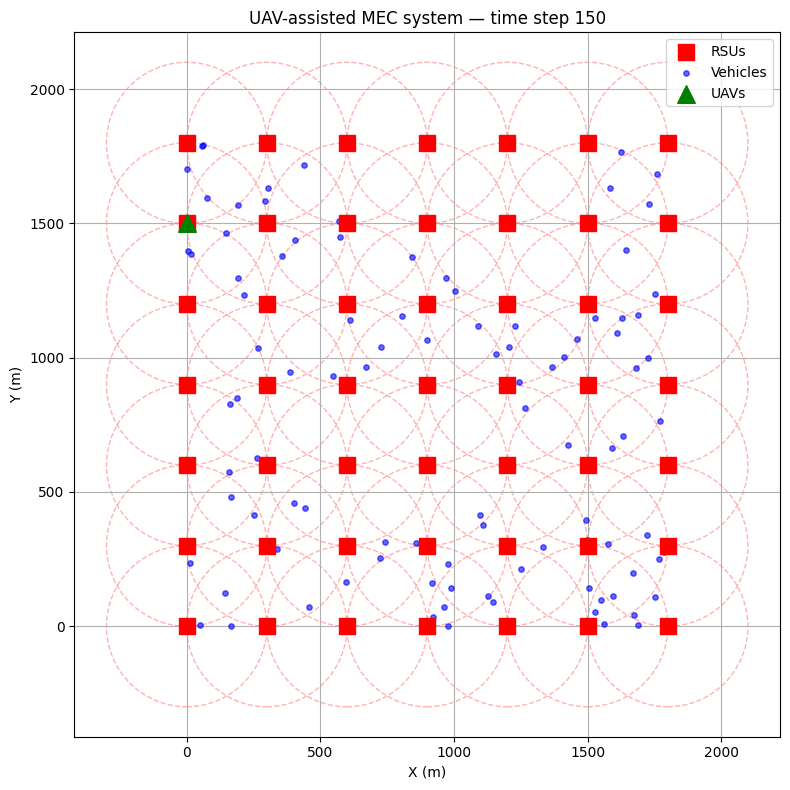

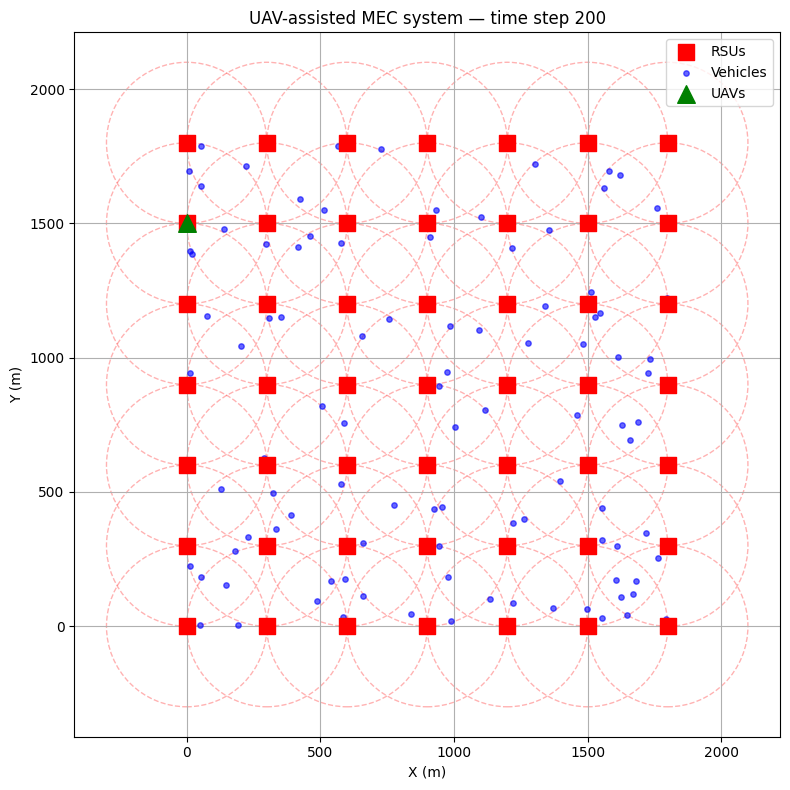

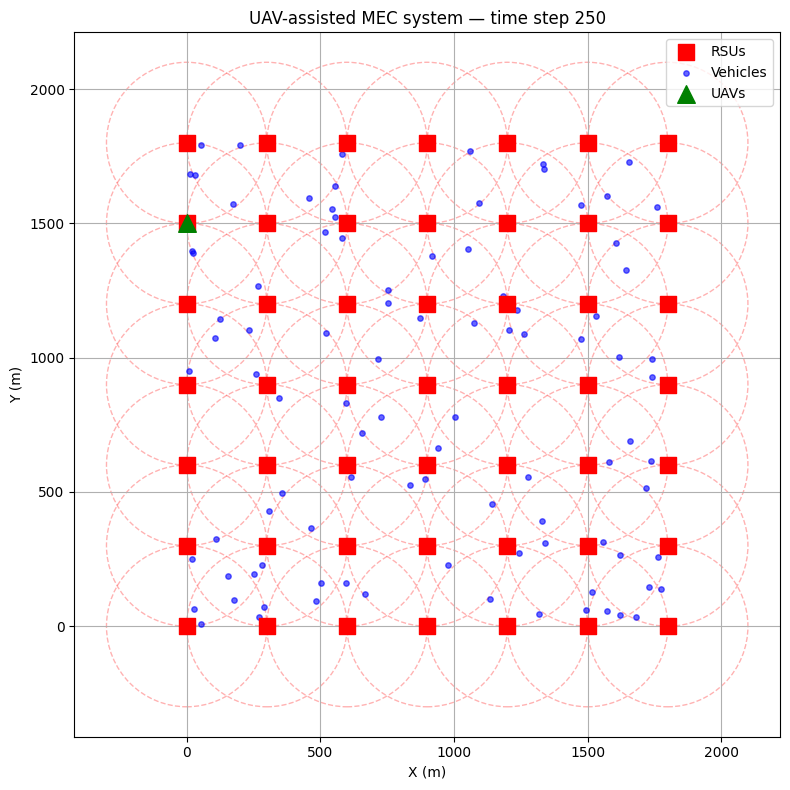

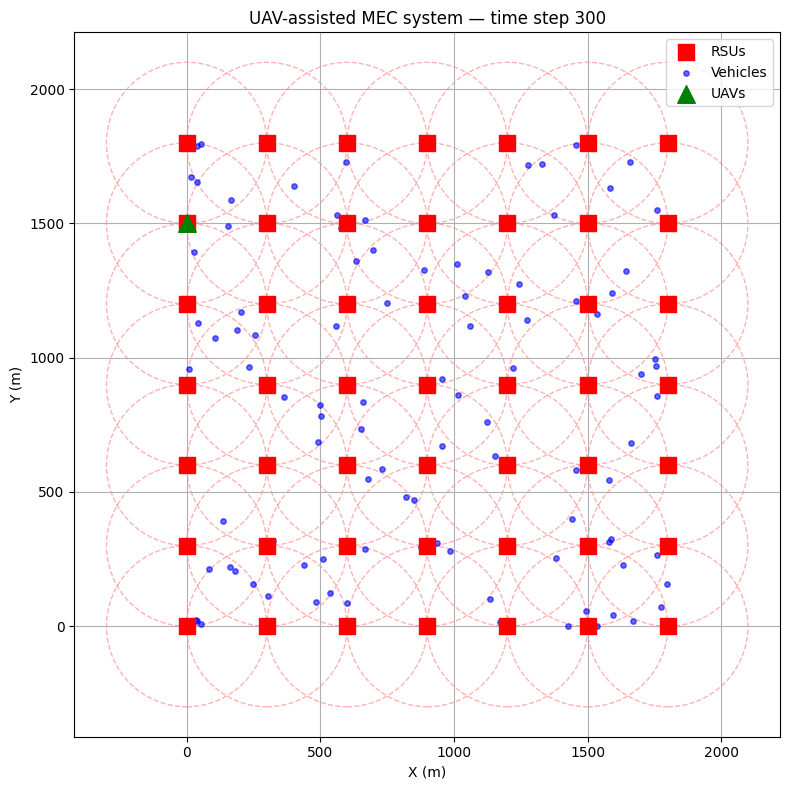

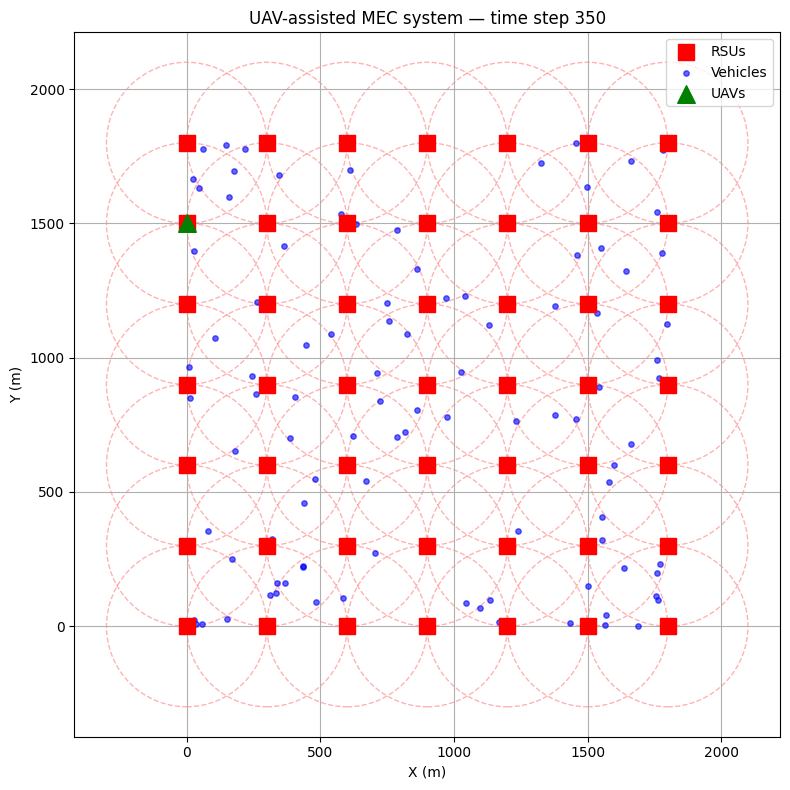

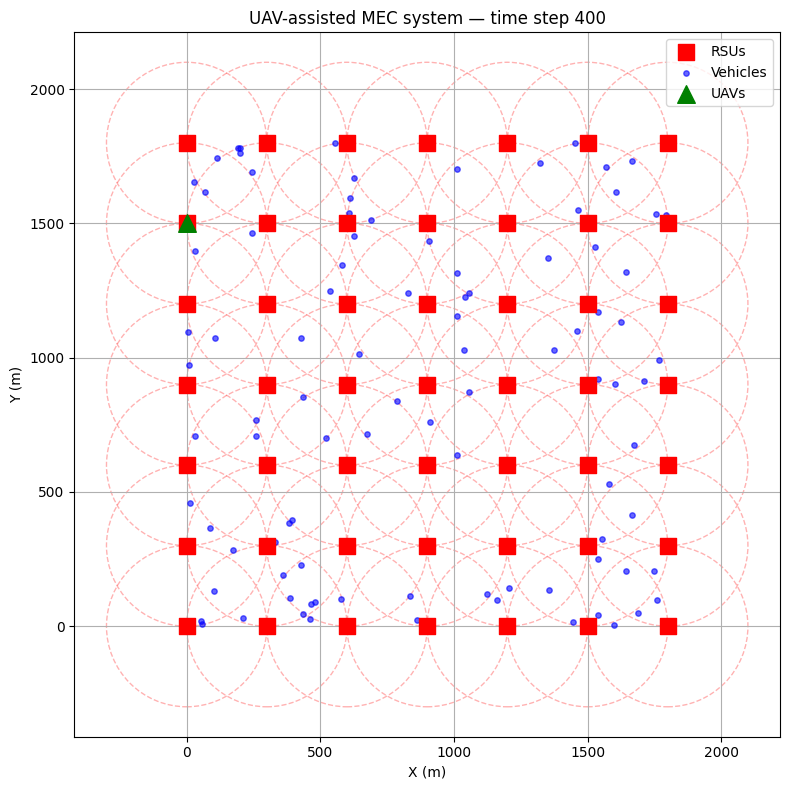

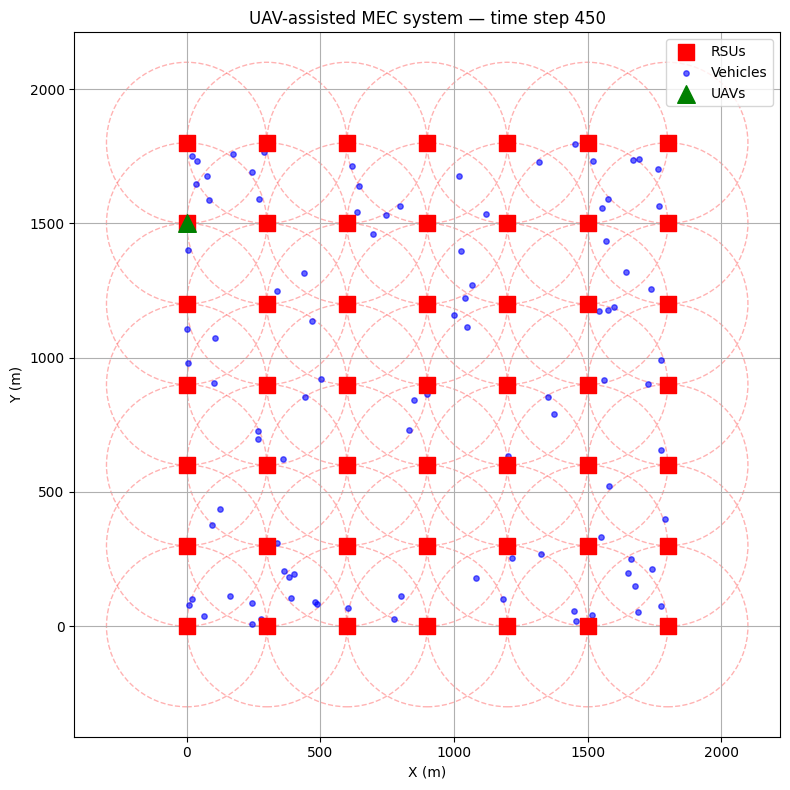

In [22]:
action = {
    "coalitions": {
        0: [0, 1],      # Coalition C0 → UAV 0 and UAV 1
        1: [2],         # Coalition C1 → UAV 2 alone
    },
    "rsu_assignment": {
        5: 0,           # RSU 5 is served by coalition C0
        12: 1,          # RSU 12 is served by coalition C1
    }
}

for t in range(T):

    # world step
    info = world.step(action)

    # plot every 50 steps
    if t % 50 == 0:
        plot_world(
            vehicles=world.vehicles,
            rsus=world.rsus,
            uavs=world.uavs,
            t=t,
            rsu_radius=world.rsu_radius
        )
        
world.reset()


In [21]:
#timestep 2
action = {
    "coalitions": {
        0: [0]
    },
    "rsu_assignment": {
        1: 0
    }
}
info = world.step(action)
info

{'time_slot': 2,
 'veh_stats': {'veh_tasks': {0: 0,
   1: 0,
   2: 0,
   3: 0,
   4: 0,
   5: 1,
   6: 0,
   7: 1,
   8: 0,
   9: 1},
  'rsu_upload_delay': {0: 0.004741014358821125,
   1: 0.0,
   2: 0.0017778803845579219}},
 'uav_results': {0: [], 1: [], 2: [], 3: [], 4: []},
 'rsu_stats': {'T_comp_rsu': {0: 0.10625, 1: 0.0, 2: 0.0625},
  'T_queue_rsu': {0: 1000000.0, 1: 0.0, 2: 1000000.0},
  'T_output_rsu': {0: 0.005, 1: 0.0, 2: 0.0025}},
 'uav_energy': {0: 500000.0,
  1: 500000.0,
  2: 500000.0,
  3: 500000.0,
  4: 500000.0},
 'overloaded_rsus': [0, 2]}

In [23]:
#timestep 3
action = {
    "coalitions": {
        0: [0, 1],
        1: [2, 3],
        2: [4]
    },
    "rsu_assignment": {
        0: 0,
        1: 1,
        2: 2
    }
}
info = world.step(action)
info

{'time_slot': 4,
 'veh_stats': {'veh_tasks': {0: 0,
   1: 0,
   2: 0,
   3: 1,
   4: 1,
   5: 0,
   6: 0,
   7: 0,
   8: 0,
   9: 2},
  'rsu_upload_delay': {0: 0.004741014358821125,
   1: 0.0035557607691158438,
   2: 0.0}},
 'uav_results': {0: [{'served_rsu': 0,
    'offloaded_cycles_cpu': 350000000.0,
    'offloaded_cycles_gpu': 150000000.0,
    'offloaded_bits': 500000.0,
    'T_uav_trans': 0.0007491470801123451,
    'T_uav_comp': 0.07,
    'T_uav_output': 7.49147080112345e-05,
    'E_comp': 0.89,
    'E_hover': 15.581293593387187,
    'E_fly': np.float64(0.0),
    'E_total': np.float64(16.471293593387188)}],
  1: [{'served_rsu': 0,
    'offloaded_cycles_cpu': 175000000.0,
    'offloaded_cycles_gpu': 75000000.0,
    'offloaded_bits': 250000.0,
    'T_uav_trans': 0.00037457354005617253,
    'T_uav_comp': 0.035,
    'T_uav_output': 3.745735400561725e-05,
    'E_comp': 0.445,
    'E_hover': 7.7906467966935935,
    'E_fly': np.float64(0.0),
    'E_total': np.float64(8.235646796693594)}],